# Задача

Чтобы оптимизировать производственные расходы, металлургический комбинат решил уменьшить потребление электроэнергии на этапе обработки стали. Нам предстоит построить модель, которая предскажет температуру стали.

# Загрузка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### Описание данных

Данные состоят из файлов, полученных из разных источников:

- `data_arc.csv` — данные об электродах;
- `data_bulk.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas.csv` — данные о продувке сплава газом;
- `data_temp.csv` — результаты измерения температуры;
- `data_wire.csv` — данные о проволочных материалах (объём);
- `data_wire_time.csv` — данные о проволочных материалах (время).

In [2]:
data_arc = pd.read_csv('data_arc.csv')
data_bulk = pd.read_csv('data_bulk.csv')
data_bulk_time = pd.read_csv('data_bulk_time.csv')
data_gas = pd.read_csv('data_gas.csv')
data_temp = pd.read_csv('data_temp.csv')
data_wire = pd.read_csv('data_wire.csv')
data_wire_time = pd.read_csv('data_wire_time.csv')

```python

# код ревьюера для обеспечения возможности дальнейшей проверки

def load_csv(file_name):
    try:
        return pd.read_csv(file_name)
    except:
        return pd.read_csv(f'/datasets/final_steel/{file_name}')
    
data_arc = load_csv('data_arc.csv')
data_bulk = load_csv('data_bulk.csv')
data_bulk_time = load_csv('data_bulk_time.csv')
data_gas = load_csv('data_gas.csv')
data_temp = load_csv('data_temp.csv')
data_wire = load_csv('data_wire.csv')
data_wire_time = load_csv('data_wire_time.csv')

```

# Предобработка данных

In [3]:
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


Пропусков нет

Изменим названия столбцов

In [4]:
data_arc.columns = ['key', 'start_heating', 'end_heating', 'active_power', 'reactive_power']

In [5]:
data_arc.head()

,key,start_heating,end_heating,active_power,reactive_power
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397


Изменим тип данных столбцов start_heating и end_heating

In [6]:
data_arc['start_heating'] =  pd.to_datetime(data_arc['start_heating'], format='%Y-%m-%d %H:%M:%S')
data_arc['end_heating'] =  pd.to_datetime(data_arc['end_heating'], format='%Y-%m-%d %H:%M:%S')

In [7]:
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   key             14876 non-null  int64         
 1   start_heating   14876 non-null  datetime64[ns]
 2   end_heating     14876 non-null  datetime64[ns]
 3   active_power    14876 non-null  float64       
 4   reactive_power  14876 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.2 KB


Посмотрим на распределения активной и реактивной мощности

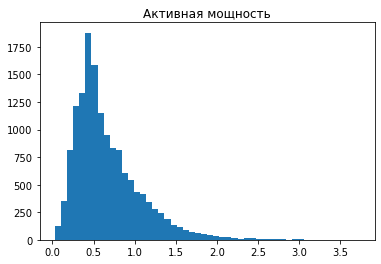

In [8]:
plt.hist(data_arc['active_power'], bins=50)
plt.title('Активная мощность')
plt.show()

Есть небольшие отклонения в правую сторону  
Нулевых значений нет  

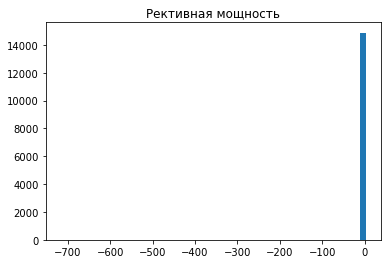

In [9]:
plt.hist(data_arc['reactive_power'], bins=50)
plt.title('Рективная мощность')
plt.show()

Есть сильные отрицательные значения. Посмотрим сколько их

In [10]:
data_arc[data_arc['reactive_power'] < 0]

,key,start_heating,end_heating,active_power,reactive_power
9780,2116,2019-07-24 00:44:48,2019-07-24 00:46:37,0.495782,-715.504924


Всего одно наблюдение. Можно удалить эту партию

In [11]:
data_arc = data_arc[data_arc['key'] != 2116].reset_index(drop=True)

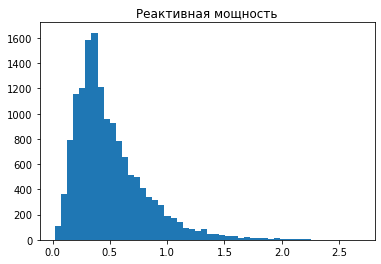

In [12]:
plt.hist(data_arc['reactive_power'], bins=50)
plt.title('Реактивная мощность')
plt.show()

Распределение выглядит лучше  
Присутствуют небольшие выбросы в положительную сторону    
Нулевых значений нет

Для обучения модели добавим несколько дополнительных признаков. А именно: время нагрева, энергию и полную мощность

In [13]:
data_arc.head()

,key,start_heating,end_heating,active_power,reactive_power
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397


In [14]:
# Время нагрева

data_arc['heating_time'] = (data_arc['end_heating'] - data_arc['start_heating']).astype('timedelta64[s]')

Если заранее известно значение мощности и времени, можно вычислить энергию, представляющую собой произведение обеих величин  
W = Р х Т  
где W — энергия, выраженная в джоулях;  
Т — время в секундах;  
Р — мощность в ваттах.

In [15]:
# Энергия

data_arc['energy'] = data_arc['active_power'] * data_arc['heating_time']

Полная мощность – это геометрически вычисляемая величина, равная корню из суммы квадратов активной и реактивной мощностей соответственно.

In [16]:
# полная мощность

data_arc['full_power'] = np.sqrt(data_arc['active_power'] ** 2 + data_arc['reactive_power'] ** 2)

In [17]:
data_arc.head()

,key,start_heating,end_heating,active_power,reactive_power,heating_time,energy,full_power
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084,228.0,222.541395,1.193639
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285,185.0,149.037310,0.959010
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805,172.0,128.030509,0.896038
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669,365.0,605.667332,1.970470
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397,148.0,102.527702,0.807239


Для обучения модели из этих признаков нам понадобятся energy, heating_time и full_power. Просуммируем их, сгруппировав по значению key. Получившуюся таблицу сохраним в новый датафрейм

In [18]:
data_arc_model = pd.DataFrame(data_arc.groupby('key', as_index=False)[['energy', 'full_power', 'heating_time']].sum())

In [19]:
data_arc_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3213 entries, 0 to 3212
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           3213 non-null   int64  
 1   energy        3213 non-null   float64
 2   full_power    3213 non-null   float64
 3   heating_time  3213 non-null   float64
dtypes: float64(3), int64(1)
memory usage: 125.5 KB


In [20]:
data_arc_model.head()

,key,energy,full_power,heating_time
0,1,1207.804249,5.826395,1098.0
1,2,733.816470,3.649216,811.0
2,3,443.583327,2.989534,655.0
3,4,670.663327,3.814962,741.0
4,5,997.496095,4.035758,869.0


Посмотрим на распределения значений признаков

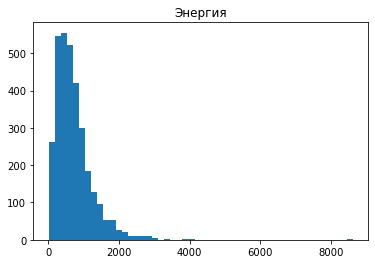

In [21]:
plt.hist(data_arc_model['energy'], bins=50)
plt.title('Энергия')
plt.show()

Присутствуют большие выбросы в положительном направлении  
Они могут помешать нам при обучении модели, поэтому их стоит удалить  
Далее все выбросы я буду устранять при помощи процентилей

In [22]:
threshold = data_arc_model['energy'].quantile(0.999)
print(threshold)

3313.5949020526514


In [23]:
data_arc_model = data_arc_model[data_arc_model['energy'] < threshold].reset_index(drop=True)

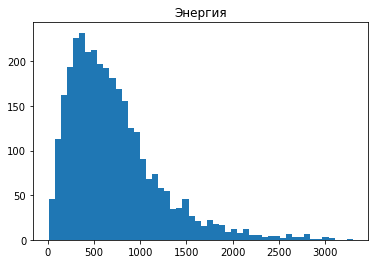

In [24]:
plt.hist(data_arc_model['energy'], bins=50)
plt.title('Энергия')
plt.show()

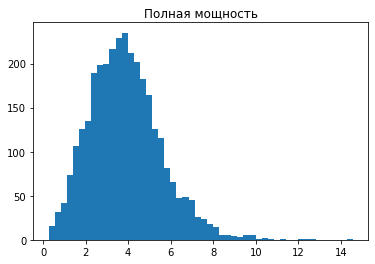

In [25]:
plt.hist(data_arc_model['full_power'], bins=50)
plt.title('Полная мощность')
plt.show()

Есть небольшие отклонения в правую сторону  
Нулевых значений нет

In [26]:
threshold = data_arc_model['full_power'].quantile(0.999)
print(threshold)

11.911154035202605


In [27]:
data_arc_model = data_arc_model[data_arc_model['full_power'] < threshold].reset_index(drop=True)

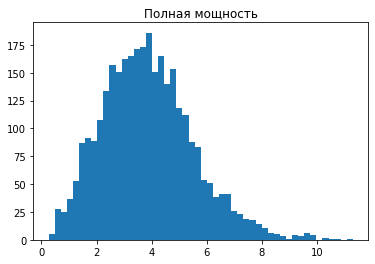

In [28]:
plt.hist(data_arc_model['full_power'], bins=50)
plt.title('Полная мощность')
plt.show()

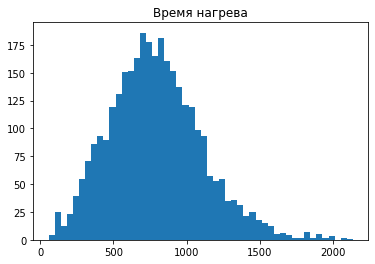

In [29]:
plt.hist(data_arc_model['heating_time'], bins=50)
plt.title('Время нагрева')
plt.show()

Заметных выбросов нет  
Нулевых значений тоже нет

In [30]:
data_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


Приведем названия столбцов в нижний змеиный регистр

In [31]:
data_bulk.columns = [column.lower().replace(' ', '_') for column in data_bulk.columns]

In [32]:
data_bulk.head()

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


Предлагаю оставить в качестве отдельного признака столбцы с минимальным количеством пропусков, а остальные суммировать.

In [33]:
data_bulk.isna().sum().sort_values(ascending=False)

bulk_8     3128
bulk_13    3111
bulk_9     3110
bulk_2     3107
bulk_7     3104
bulk_5     3052
bulk_10    2953
bulk_11    2952
bulk_1     2877
bulk_6     2553
bulk_4     2115
bulk_3     1831
bulk_15     881
bulk_12     679
bulk_14     323
key           0
dtype: int64

Больше всего добавляют вещества 14, 12 и 15

In [34]:
data_bulk = data_bulk.fillna(0)

In [35]:
data_bulk['bulk_other'] = \
data_bulk['bulk_1'] + data_bulk['bulk_2'] + data_bulk['bulk_3'] + data_bulk['bulk_4'] + data_bulk['bulk_5'] + \
data_bulk['bulk_6'] + data_bulk['bulk_7'] + data_bulk['bulk_8'] + data_bulk['bulk_9'] + data_bulk['bulk_10'] + \
data_bulk['bulk_11'] + data_bulk['bulk_13']

In [36]:
data_bulk.head()

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,bulk_other
0,1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0,43.0
1,2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0,73.0
2,3,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0,34.0
3,4,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0,81.0
4,5,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0,78.0


Сохраним нужные признаки в отдельную таблицу

In [37]:
data_bulk_model = data_bulk[['key', 'bulk_12', 'bulk_14', 'bulk_15', 'bulk_other']]

In [38]:
data_bulk_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   key         3129 non-null   int64  
 1   bulk_12     3129 non-null   float64
 2   bulk_14     3129 non-null   float64
 3   bulk_15     3129 non-null   float64
 4   bulk_other  3129 non-null   float64
dtypes: float64(4), int64(1)
memory usage: 122.4 KB


In [39]:
data_bulk_model.head()

,key,bulk_12,bulk_14,bulk_15,bulk_other
0,1,206.0,150.0,154.0,43.0
1,2,206.0,149.0,154.0,73.0
2,3,205.0,152.0,153.0,34.0
3,4,207.0,153.0,154.0,81.0
4,5,203.0,151.0,152.0,78.0


In [40]:
data_gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


Пропущенных значений нет

Изменим название столбца

In [41]:
data_gas.columns = ['key', 'gas']

In [42]:
data_gas.head()

,key,gas
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


Посмотрим на распределение значений признака

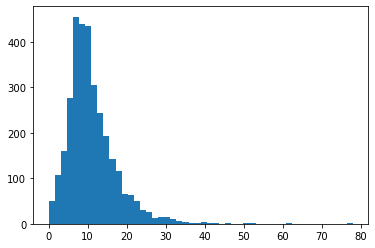

In [43]:
plt.hist(data_gas['gas'], bins=50)
plt.show()

Присутствуют большие выбросы в положительную сторону

In [44]:
threshold = data_gas['gas'].quantile(0.995)
print(threshold)

34.67939301926596


In [45]:
data_gas = data_gas[data_gas['gas'] < threshold].reset_index(drop=True)

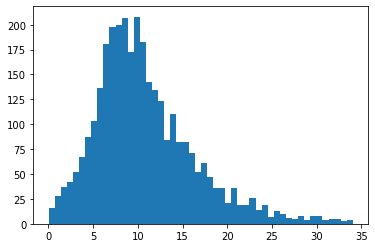

In [46]:
plt.hist(data_gas['gas'], bins=50)
plt.show()

In [47]:
data_gas[data_gas['gas'] == 0].shape[0]

0

Нулевых значений нет

In [48]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           15907 non-null  int64  
 1   Время замера  15907 non-null  object 
 2   Температура   13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


Изменим названия столбцов

In [49]:
data_temp.columns = ['key', 'measure_time', 'temperature']

In [50]:
data_temp.head()

,key,measure_time,temperature
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0


Изменим тип данных столбца measure_time

In [51]:
data_temp['measure_time'] =  pd.to_datetime(data_temp['measure_time'], format='%Y-%m-%d %H:%M:%S')

Из этого столбца нам нужны только начальные измерения температуры и наш целевой признак - последние измерения температуры

In [52]:
data_temp.tail(15)

,key,measure_time,temperature
15892,3239,2019-09-01 02:23:02,NaN
15893,3239,2019-09-01 02:24:15,NaN
15894,3240,2019-09-01 02:39:01,1617.0
15895,3240,2019-09-01 02:48:33,NaN
15896,3240,2019-09-01 03:03:21,NaN
15897,3240,2019-09-01 03:12:19,NaN
15898,3240,2019-09-01 03:19:09,NaN
15899,3240,2019-09-01 03:31:27,NaN
15900,3240,2019-09-01 03:34:31,NaN
15901,3240,2019-09-01 03:35:16,NaN


В последних партиях температура измерена лишь один раз в начале

Сохраним значения первого и последнего измерения температуры в отдельные датафреймы

In [53]:
first_temp = data_temp.sort_values('measure_time').groupby('key').head(1).reset_index(drop=True)

In [54]:
first_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3216 entries, 0 to 3215
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           3216 non-null   int64         
 1   measure_time  3216 non-null   datetime64[ns]
 2   temperature   3216 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 75.5 KB


Пропусков нет. Признак времени измерения не имеет смысла для обучения модели

In [55]:
first_temp = first_temp.drop(columns=['measure_time'])

In [56]:
first_temp.columns = ['key', 'first_temperature']

In [57]:
first_temp.head()

,key,first_temperature
0,1,1571.0
1,2,1581.0
2,3,1596.0
3,4,1601.0
4,5,1576.0


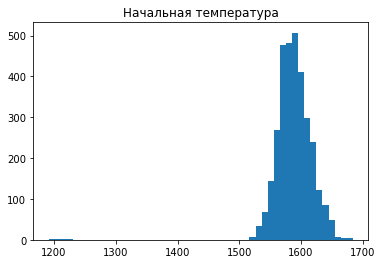

In [58]:
plt.hist(first_temp['first_temperature'], bins=50)
plt.title('Начальная температура')
plt.show()

Сильные выбросы в левом направлении

In [59]:
first_temp = first_temp[first_temp['first_temperature'] > 1500].reset_index(drop=True)

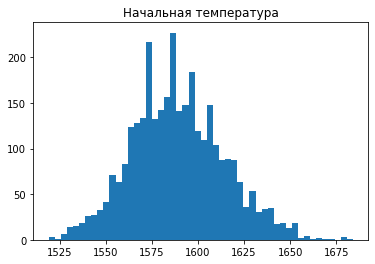

In [60]:
plt.hist(first_temp['first_temperature'], bins=50)
plt.title('Начальная температура')
plt.show()

In [61]:
last_temp = data_temp.sort_values('measure_time').groupby('key').tail(1).reset_index(drop=True)

In [62]:
last_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3216 entries, 0 to 3215
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           3216 non-null   int64         
 1   measure_time  3216 non-null   datetime64[ns]
 2   temperature   2477 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 75.5 KB


In [63]:
last_temp = last_temp.drop(columns=['measure_time'])

In [64]:
last_temp.columns = ['key', 'last_temperature']

In [65]:
last_temp.head()

,key,last_temperature
0,1,1613.0
1,2,1602.0
2,3,1599.0
3,4,1625.0
4,5,1602.0


In [66]:
last_temp.iloc[:2477].isna().sum()

key                 0
last_temperature    0
dtype: int64

In [67]:
last_temp.iloc[2477:].isna().sum()

key                   0
last_temperature    739
dtype: int64

В последних 739 партиях измерили только начальную температуру.  
Так как это наш целевой признак, пропущенные значения нам не пригодятся

In [68]:
last_temp = last_temp.iloc[:2477].reset_index(drop=True)

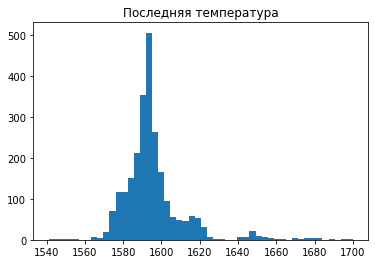

In [69]:
plt.hist(last_temp['last_temperature'], bins=50)
plt.title('Последняя температура')
plt.show()

Значения целевого признака лежат в диапазоне от 1540 до 1700

In [70]:
data_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


Приведем названия столбцов в нижний змеиный регистр

In [71]:
data_wire.columns = [column.lower().replace(' ', '_') for column in data_wire.columns]

In [72]:
data_wire.head()

,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Здесь тоже как в таблице bulk - нужно оставить в качестве отдельного признака столбцы с минимальным количеством пропусков, а остальные суммировать.

In [73]:
data_wire.isna().sum().sort_values(ascending=False)

wire_5    3080
wire_7    3070
wire_4    3067
wire_8    3062
wire_9    3052
wire_3    3018
wire_6    3008
wire_2    2002
wire_1      26
key          0
dtype: int64

Первое вещество добавляют больше всех, у остальных почти все значения пропущены.  
Предлагаю суммировать все признаки, так как пропущенных значений слишком много

In [74]:
data_wire = data_wire.fillna(0)

In [75]:
data_wire['wire_sum'] = \
data_wire['wire_1'] + data_wire['wire_2'] + data_wire['wire_3'] + data_wire['wire_4'] + data_wire['wire_5'] + \
data_wire['wire_6'] + data_wire['wire_7'] + data_wire['wire_8'] + data_wire['wire_9']

In [76]:
data_wire.head()

,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9,wire_sum
0,1,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60.059998
1,2,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,96.052315
2,3,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,91.160157
3,4,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,89.063515
4,5,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,98.352796


In [77]:
data_wire_model = data_wire[['key', 'wire_sum']]

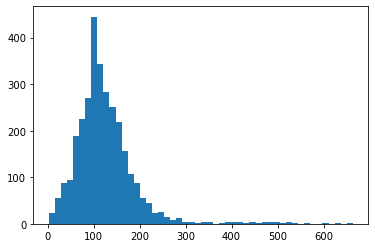

In [78]:
plt.hist(data_wire_model['wire_sum'], bins=50)
plt.show()

Есть значения сильно отклоняющиеся от среднего в правую сторону

In [79]:
threshold = data_wire_model['wire_sum'].quantile(0.985)
print(threshold)

337.9873098000004


In [80]:
data_wire_model = data_wire_model[data_wire_model['wire_sum'] < threshold].reset_index(drop=True)

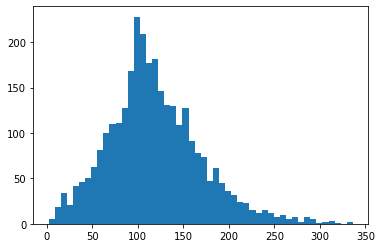

In [81]:
plt.hist(data_wire_model['wire_sum'], bins=50)
plt.show()

# Соединение таблиц

Главной таблицей является last_temp. Будем поочередно присоединять к ней остальные таблицы по ключу key

In [82]:
data = last_temp.merge(first_temp, on='key', how='left')
data = data.merge(data_arc_model, on='key', how='left')
data = data.merge(data_bulk_model, on='key', how='left')
data = data.merge(data_wire_model, on='key', how='left')
data = data.merge(data_gas, on='key', how='left')

In [83]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2477 entries, 0 to 2476
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   key                2477 non-null   int64  
 1   last_temperature   2477 non-null   float64
 2   first_temperature  2473 non-null   float64
 3   energy             2466 non-null   float64
 4   full_power         2466 non-null   float64
 5   heating_time       2466 non-null   float64
 6   bulk_12            2408 non-null   float64
 7   bulk_14            2408 non-null   float64
 8   bulk_15            2408 non-null   float64
 9   bulk_other         2408 non-null   float64
 10  wire_sum           2340 non-null   float64
 11  gas                2460 non-null   float64
dtypes: float64(11), int64(1)
memory usage: 251.6 KB


В некоторых признаках есть пропущенные значения

In [84]:
data.head()

,key,last_temperature,first_temperature,energy,full_power,heating_time,bulk_12,bulk_14,bulk_15,bulk_other,wire_sum,gas
0,1,1613.0,1571.0,1207.804249,5.826395,1098.0,206.0,150.0,154.0,43.0,60.059998,29.749986
1,2,1602.0,1581.0,733.816470,3.649216,811.0,206.0,149.0,154.0,73.0,96.052315,12.555561
2,3,1599.0,1596.0,443.583327,2.989534,655.0,205.0,152.0,153.0,34.0,91.160157,28.554793
3,4,1625.0,1601.0,670.663327,3.814962,741.0,207.0,153.0,154.0,81.0,89.063515,18.841219
4,5,1602.0,1576.0,997.496095,4.035758,869.0,203.0,151.0,152.0,78.0,98.352796,5.413692


Пропущенные значения в столбцах bulk и wire можно заполнить нулем

In [85]:
columns = ['bulk_12', 'bulk_14', 'bulk_15', 'bulk_other', 'wire_sum']
data[columns] = data[columns].fillna(0)

Остальные признаки важные, поэтому можно удалить пропущенные значения

In [86]:
data = data.dropna().reset_index(drop=True)

In [87]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2448 entries, 0 to 2447
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   key                2448 non-null   int64  
 1   last_temperature   2448 non-null   float64
 2   first_temperature  2448 non-null   float64
 3   energy             2448 non-null   float64
 4   full_power         2448 non-null   float64
 5   heating_time       2448 non-null   float64
 6   bulk_12            2448 non-null   float64
 7   bulk_14            2448 non-null   float64
 8   bulk_15            2448 non-null   float64
 9   bulk_other         2448 non-null   float64
 10  wire_sum           2448 non-null   float64
 11  gas                2448 non-null   float64
dtypes: float64(11), int64(1)
memory usage: 229.6 KB


# Дальнейший план

1. Соединить таблицы в один датафрейм по общему признаку key
2. Проверить на мультиколлинеарность признаков
3. Разделить данные на тренировочный и тестовый выборки
4. Обучить несколько моделей, подбирая гиперпараметры
5. Оценить лучшую модель на тестовой выборке
6. Добиться результата mae < 6 

# Моделирование

In [88]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

import warnings
warnings.filterwarnings('ignore')

RAND = 22

## 1. Проверка на мультиколлинеарность

<AxesSubplot:>

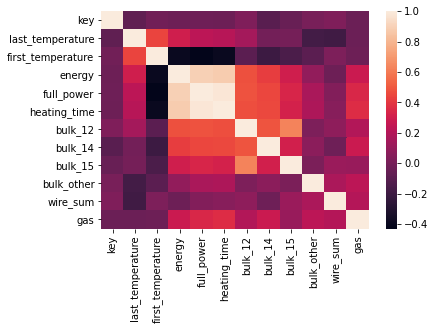

In [89]:
sns.heatmap(data.corr())

Присутствует сильная линейная зависимость между признаками full_power, energy и heating_time  
В обучение моделей стоит оставить из них всего один  
Думаю, лучшим является затраченная энергия, так как она является произведением двух остальных  

## 2. Разделение данных

In [90]:
X = data.drop(['key', 'last_temperature', 'full_power', 'heating_time'], axis=1)
y = data['last_temperature']

In [91]:
X.head()

,first_temperature,energy,bulk_12,bulk_14,bulk_15,bulk_other,wire_sum,gas
0,1571.0,1207.804249,206.0,150.0,154.0,43.0,60.059998,29.749986
1,1581.0,733.816470,206.0,149.0,154.0,73.0,96.052315,12.555561
2,1596.0,443.583327,205.0,152.0,153.0,34.0,91.160157,28.554793
3,1601.0,670.663327,207.0,153.0,154.0,81.0,89.063515,18.841219
4,1576.0,997.496095,203.0,151.0,152.0,78.0,98.352796,5.413692


In [92]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RAND)

In [93]:
X_train.shape, X_test.shape

((1958, 8), (490, 8))

## 3. Масштабирование данных

Чтобы признаки имели одинаковый вклад в обучение модели, стоит стандартизировать их

In [94]:
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns, index=X_train.index)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)

In [95]:
X_train.head()

,first_temperature,energy,bulk_12,bulk_14,bulk_15,bulk_other,wire_sum,gas
1623,0.38750,0.058338,0.000000,0.000000,0.000000,0.000000,0.440536,0.230882
2435,0.43750,0.063995,0.274910,0.163062,0.256790,0.038401,0.104318,0.175117
473,0.62500,0.054656,0.123649,0.302829,0.503704,0.043887,0.065837,0.319046
569,0.41875,0.206339,0.496999,0.439268,0.496296,0.079154,0.288958,0.324530
2434,0.39375,0.492023,0.612245,0.347754,0.256790,0.076803,0.563021,0.382972


In [96]:
X_test.head()

,first_temperature,energy,bulk_12,bulk_14,bulk_15,bulk_other,wire_sum,gas
1475,0.33125,0.110556,0.000000,0.331115,0.000000,0.160658,0.447310,0.394133
869,0.52500,0.028223,0.000000,0.000000,0.000000,0.026646,0.437156,0.247198
2262,0.40000,0.155622,0.246098,0.241265,0.251852,0.000000,0.524069,0.295938
122,0.53125,0.119560,0.429772,0.346090,0.501235,0.167712,0.176159,0.177808
824,0.48125,0.196483,0.581032,0.337770,0.501235,0.048589,0.416735,0.333750


## 4. Baseline

### Linear Regression

In [97]:
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mean_absolute_error(y_test, y_pred)

7.9428736219836775

### Random Forest

In [98]:
model = RandomForestRegressor(random_state=RAND)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mean_absolute_error(y_test, y_pred)

6.4831428571428535

### Cat Boost

In [99]:
model = CatBoostRegressor(random_state=RAND, verbose=False)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mean_absolute_error(y_test, y_pred)

6.387826325208092

### LightGBM

In [100]:
model = LGBMRegressor(random_state=RAND)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mean_absolute_error(y_test, y_pred)

6.635722034291112

Алгоритмы, основанные на деревьях решений, дают результаты лучше, чем линейная модель  
Лучший результат показал алгоритм градиентного бустинга CatBoost  
Попробуем подобрать гиперпараметры для этих трех ансамблей

## 5. Подбор гиперпараметров

### Random Forest

In [101]:
model = RandomForestRegressor(random_state=RAND)

parameters = {
    'max_depth': [5, 8, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5]
}

grid = GridSearchCV(model, parameters, cv=5, verbose=2)

In [102]:
# grid.fit(X_train, y_train)

In [103]:
# grid.best_params_

# {'max_depth': 15, 'min_samples_leaf': 2, 'min_samples_split': 5}

In [104]:
model = RandomForestRegressor(min_samples_leaf=2, random_state=RAND)

parameters = {
    'max_depth': [10, 12, 15, 17, 20],
    'min_samples_split': [3, 4, 5, 6, 7],
}

grid = GridSearchCV(model, parameters, cv=5, verbose=2)

In [105]:
# grid.fit(X_train, y_train)

In [106]:
# grid.best_params_

# {'max_depth': 12, 'min_samples_split': 5}

In [107]:
model = RandomForestRegressor(min_samples_leaf=2, min_samples_split=5, random_state=RAND)

parameters = {
    'max_depth': [11, 12, 13, 14]
}

grid = GridSearchCV(model, parameters, cv=5, verbose=2)

In [108]:
# grid.fit(X_train, y_train)

In [109]:
# grid.best_params_

# {'max_depth': 12}

In [110]:
best_params = {'max_depth': 12, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators':1000}
model = RandomForestRegressor(**best_params, random_state=RAND)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mean_absolute_error(y_test, y_pred)

6.453284440963834

### LightGBM

In [111]:
model = LGBMRegressor(random_state=RAND)

parameters = {
    'max_depth': [5, 7, 10],
    'num_leaves': [50, 80, 110],
    'n_estimators': [100, 300, 500]
}

grid = GridSearchCV(model, parameters, cv=5, verbose=2)

In [112]:
# grid.fit(X_train, y_train)

In [113]:
# grid.best_params_

# {'max_depth': 5, 'n_estimators': 100, 'num_leaves': 50}

In [114]:
model = LGBMRegressor(random_state=RAND)

parameters = {
    'max_depth': [4, 5, 6],
    'num_leaves': [30, 50, 70],
    'n_estimators': [50, 100, 150]
}

grid = GridSearchCV(model, parameters, cv=5, verbose=2)

In [115]:
# grid.fit(X_train, y_train)

In [116]:
# grid.best_params_

# {'max_depth': 4, 'n_estimators': 100, 'num_leaves': 30}

In [117]:
model = LGBMRegressor(random_state=RAND)

parameters = {
    'max_depth': [2, 3, 4],
    'num_leaves': [20, 30, 40],
    'n_estimators': [75, 100, 125]
}

grid = GridSearchCV(model, parameters, cv=5, verbose=2)

In [118]:
# grid.fit(X_train, y_train)

In [119]:
# grid.best_params_

# {'max_depth': 3, 'n_estimators': 100, 'num_leaves': 20}

In [120]:
model = LGBMRegressor(max_depth=3, random_state=RAND)

parameters = {
    'num_leaves': [5, 10, 15, 20, 25],
    'n_estimators': [80, 90, 100, 110, 120]
}

grid = GridSearchCV(model, parameters, cv=5, verbose=2)

In [121]:
# grid.fit(X_train, y_train)

In [122]:
# grid.best_params_

# {'n_estimators': 120, 'num_leaves': 5}

In [123]:
model = LGBMRegressor(max_depth=3, random_state=RAND)

parameters = {
    'num_leaves': range(2, 10),
    'n_estimators': range(111, 125)
}

grid = GridSearchCV(model, parameters, cv=5, verbose=2)

In [124]:
# grid.fit(X_train, y_train)

In [125]:
# grid.best_params_

# {'n_estimators': 120, 'num_leaves': 5}

In [126]:
best_params = {'max_depth': 3, 'n_estimators': 120, 'num_leaves': 5}
model = LGBMRegressor(**best_params, random_state=RAND)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mean_absolute_error(y_test, y_pred)

6.498032825729385

### Cat Boost

In [127]:
model = CatBoostRegressor(random_state=RAND)

parameters = {
    'depth': [6, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'iterations': [30, 50, 100]
}

grid = GridSearchCV(model, parameters, cv=5, verbose=2)

In [128]:
# grid.fit(X_train, y_train)

In [129]:
# grid.best_params_

# {'depth': 6, 'iterations': 100, 'learning_rate': 0.1}

In [130]:
model = CatBoostRegressor(random_state=RAND, learning_rate=0.1)

parameters = {
    'depth': range(1, 8),
    'iterations': [100, 150, 300, 600, 1000]
}

grid = GridSearchCV(model, parameters, cv=5, verbose=2)

In [131]:
# grid.fit(X_train, y_train)

In [132]:
# grid.best_params_

# {'depth': 7, 'iterations': 150}

In [133]:
model = CatBoostRegressor(random_state=RAND, learning_rate=0.1, depth=7)

parameters = {
    'iterations': range(110, 300, 10)
}

grid = GridSearchCV(model, parameters, cv=5, verbose=2)

In [134]:
# grid.fit(X_train, y_train)

In [135]:
# grid.best_params_

# {'iterations': 140}

In [136]:
model = CatBoostRegressor(random_state=RAND, learning_rate=0.1, depth=7)

parameters = {
    'iterations': range(131, 150)
}

grid = GridSearchCV(model, parameters, cv=5, verbose=2)

In [137]:
# grid.fit(X_train, y_train)

In [138]:
# grid.best_params_

# {'iterations': 137}

In [139]:
best_params = {'learning_rate': 0.1, 'depth': 7, 'iterations': 137}
model = CatBoostRegressor(**best_params, random_state=RAND, verbose=False)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mean_absolute_error(y_test, y_pred)

6.386678537880181

Лучший результат показал алгоритм градиентного бустинга CatBoost.  
Его метрика на тестовой выборке составила 6.38  
Сравним её с константной моделью

### Константная модель 

In [140]:
# Среднее

y_pred = pd.Series(y_train.mean(), index=y_test.index)
mean_absolute_error(y_test, y_pred)

9.791138396114325

In [141]:
# Медиана

y_pred = pd.Series(y_train.median(), index=y_test.index)
mean_absolute_error(y_test, y_pred)

9.479591836734693

Метрика MAE константной модели составила 9.48  
Наша модель прошла тест на адекватность!

# Отчет по решению

Краткий обзор выполненной работы:

1. Загрузка данных (7 таблиц)
2. Предобработка данных (работа с пропусками, обработка аномалий)
3. Добавление дополнительных признаков (энергия, время нагрева, полная мощность)
4. Присоединение таблиц
5. Проверка на мультиколлинеарность
6. Масштабирование данных
7. Обучение моделей без настроенных гиперпараметров (лучший - CatBoost 6.38)
8. Обучение моделей с подбором гиперпараметров (лучший - CatBoost 6.38)
9. Сравнение с константной моделью (CatBoost 6.38 < Median 9.48)  